\title{Time Analysis}

\author{John Mateus-R}

With this algorithm we make an initial analysis for simulation parameters $\delta t$ and $N_{\text{iter}}$, which depends on the initial particle number, $N_0$, critical length fusion, $l_f$ and inverse temperature, $\beta$, as follows:
$$
    \delta t = 2\left(\frac{\pi}{N_0}\right)^2\left(\frac{l_f}{10}\right)^2\beta\,,\qquad N_{\text{iter}} = \frac{100}{\delta t}\,.
$$

(Note that Niter ensures that the total time for fusion process is around $10^2$ virtual seconds).

To make the analysis we start with two arrays for $l_f$ and $\beta$: $l_f=\{0.1, 0.5, 1.0, 1.5, ... , 8.0\}$ and $\beta = \{0.1, 0.2, 0.4, ... , 4.0\}$ and calculates $\delta t$ for each pair of values $(l_f, \beta)$. With this in mind we finally have a data matrix for all $\delta t$ values.

The matrix found is mapped into a matrix with its entries are the magnitud order (MO) of $\delta t$ values. The idea here is find the regions with same MO and then test the time to takes run the simulation script for the fusion process.

We select some pairs of values $(l_f, \beta)$ to test in the cluster for the simulation script. The script is submited in the cluster and we register the time that script takes to perform all calculus.

For this process we take three regions:

\begin{enumerate}

\item Region A: $dt=10^{-6}$, $N_{\text{iter}}=10^8$.
    
\item Region B: $dt=10^{-5}$, $N_{\text{iter}}=10^7$.
    
\item Region C: $dt=10^{-4}$, $N_{\text{iter}}=10^6$.

\end{enumerate}

For each region we choose some values for lf and beta as follows:
    
\begin{enumerate}

\item Region A: $l_f = \{0.5, 1.0, 3.5, 6.0\}$, $\beta = \{0.1, 1.0, 3.0\}$.
    
\item Region B: $l_f = \{1.5, 3.0, 5.0, 7.5\}$, $\beta = \{0.1, 1.0, 3.0\}$.
    
\item Region C: $l_f = \{4.0, 5.0, 6.0, 7.0, 8.0\}$, $\beta = \{0.8, 1.8, 3.0, 4.0\}$.
   
\end{enumerate}

Furthermore, to make a statistics, the script is subimted using --array=0-xx option in sbatch where xx takes the values xx = {50, 100, 150}. The other parameters for run the script are:

\begin{itemize}

\item N=100       \# Initial particle number
    
\item Nsim=1      \# Total number of simulations
    
\item Nsimst=1    \# Name for the fisrt simulation
    
\item stf=0       \# Initialize the fusion process at virtual time = 0
   
\end{itemize}

In [1]:
#----------------Import libraries----------------#

from math import log10, floor
import numpy as np
import pandas as pd
import matplotlib as pl
import matplotlib.pyplot as pl
import matplotlib.gridspec as gs

In [2]:
#----------------Functions defintions----------------#

    # Print number in scientific notation:
def sci_num(number):
    num = np.format_float_scientific(number, precision = 0, exp_digits=1)
    return num.replace('.', '')

    # Creates data file name:
def read_data_file_name(Niter, dt, CPU):
    return 'Niter'+str(Niter)+'_dt'+str(sci_num(dt))+'_CPU'+str(CPU)+'.csv'

    # Calculates dt time step as a function of number particles, fusion lenght and beta:
def delta_t(N0, LF, BETA):
    dt = 2*((np.pi*LF)/(10*N0))**2*BETA
    return dt

    # Find the magnitud order of a given number
def find_exp(number) -> int:
    base10 = log10(abs(number))
    return floor(base10)

    # Find average times and std for data:
def Average_Time(k, DT, lf, beta, CPU):
    k = 1
    T_lf = pd.DataFrame()
    for i in range(len(lf[k])):
        n = len(beta[k])
        aux = pd.DataFrame()
        for j in range(len(CPU)):
            fst_mean = np.mean(DT['Mean_t(min)_'+str(CPU[j])][n*i:n*(i+1)])
            fst_std = np.mean(DT['Std_t(min)_'+str(CPU[j])][n*i:n*(i+1)])
            aux1 = pd.DataFrame([[fst_mean, fst_std]], columns=['Total_time', 'Std_Time'])
            aux = pd.concat([aux, aux1], ignore_index=True)
        scn_mean = np.mean(aux['Total_time'])
        scn_std = np.mean(aux['Std_Time'])
        aux2 = pd.DataFrame([[lf[k][i], scn_mean, scn_std]], columns=['lf', 'Total_time', 'Std_Time'])
        T_lf = pd.concat([T_lf, aux2], ignore_index=True)
    return T_lf

In [3]:
#----------------General parameters----------------#

N=100       # Initial particle number
Nsim=1      # Total number of simulations
Nsimst=1    # Name for the fisrt simulation
stf=0       # Initialize the fusion process at virtual time = 0

    # Lenghts fusion values for test:
Lf = [0.1, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0]
    # Beta values for test:
Betas = [0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0]

    # Creates a matrix of delta t values for each pair of parameters lf and beta:
DTs = np.empty([len(Lf), len(Betas)])

    # Creates a matrix of magnitud order (MO) for delta t for each pair of parameters lf and beta:
DTs_Exps = np.empty([len(Lf), len(Betas)])
for i in range(len(Lf)):
    for j in range(len(Betas)):
        DTs[i][j] = delta_t(N, Lf[i], Betas[j])
        DTs_Exps[i][j] = find_exp(delta_t(N, Lf[i], Betas[j]))

    # Converts the array DTs to data frame DT (best screen visualization):
DT = pd.DataFrame(DTs, index=Lf, columns=Betas)
DT_Exps = pd.DataFrame(DTs_Exps, index=Lf, columns=Betas)
#print(DT)
#print(DT_Exps)

Once we have all initial data parameters, we proceded with the analysis for the regions of possible interest. The idea is find the optimal pairs $(l_f, \beta)$ for which $\delta t$ and $N_{\text{iter}}$ allow us work with practical times in the cluster when we run the simulation script.

For this purpose we make a count of $\delta t$-MO for each value of $\beta$ (a histogram of $\delta t$-MO). To normalize all data we sum over each $\beta$ value for all $\delta t$-MO and thus find the complete histogram of $\delta t$-MO.

In [4]:
#----------------Data Organization----------------#

    # Makes a "histogram" of dt-MO for each value of beta-parameter:
His_aux = DT_Exps.apply(pd.Series.value_counts)
His_aux = His_aux.fillna(0) # Replace all NaN values with zeros

His = pd.DataFrame() # Makes final count-histogram of dt-MO
for i in His_aux.index:
    aux = 0
    for j in Betas:
        aux = aux+His_aux[j][i]
    Aux = pd.DataFrame([[i, aux]], columns=['OM_dt', 'N_OM_dt'])
    His = pd.concat([His, Aux], ignore_index=True)

n_Dt = sum(His['N_OM_dt']) # Finds total data present in the dt-MO-histogram
His['N_OM_dt'] = His['N_OM_dt']/n_Dt # Normalize data points

Maxs = DT_Exps.max() # Finds Maxs values per column in dt-MO data:
Max = Maxs.max() # Finds Max value in dt-MO data:
Mins = DT_Exps.min() # Finds Mins values per column in dt-MO data:
Min = Mins.min() # Finds Min value in dt-MO data:

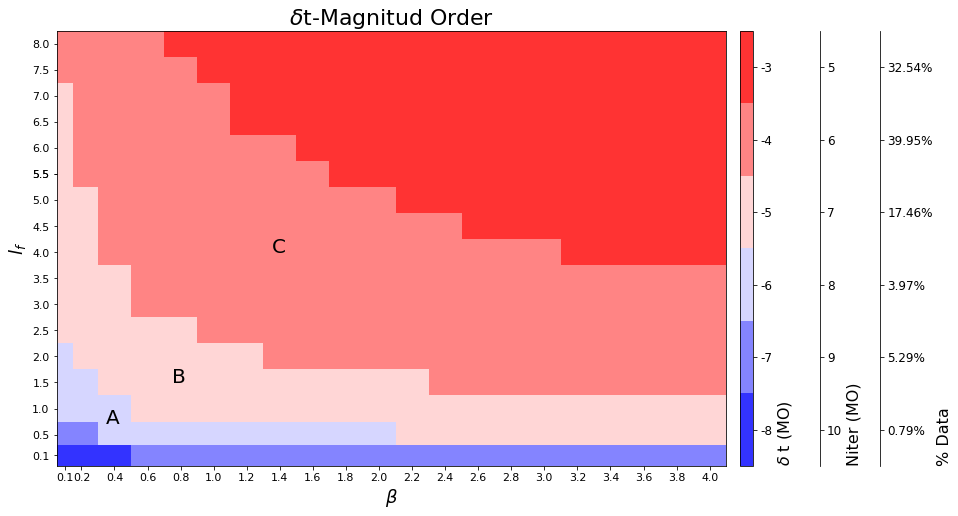

In [5]:
#----------------Now start to make the plots----------------#

dt_ticks = np.arange(Min, Max+1) # Ticks for the x-axis and 1st colorbar
Niter_ticks = 2-dt_ticks # Ticks for 2nd color bar
Percent_ticks = His['N_OM_dt'].to_numpy() # Ticks for 3rd color bar

cmap = pl.get_cmap('bwr', Max-Min+1)

fig, ax = pl.subplots(figsize=(12, 8))

    # Initial settings for the plot:
ax.set_title(r'$\delta$t-Magnitud Order', size=22)
ax.tick_params(axis='both', labelsize=11)
ax.set_xlabel(r'$\beta$', size=18)
ax.set_ylabel(r'$l_f$', size=18)
ax.set_xticks(Betas)
ax.set_yticks(Lf)

f = ax.pcolormesh(Betas, Lf, DT_Exps, cmap=cmap, alpha=0.8, vmin=Min-0.5, vmax=Max+0.5)

    # Set the color bars convention (dt-MO, Niter-MO, percent data present):
ax1 = ax.inset_axes([1.02, 0, 0.02, 1]) # 1st color bar for dt-MO
cb1 = pl.colorbar(f, cax=ax1, ticks=dt_ticks)
cb1.set_label(r'$\delta$ t (MO)', size=16, loc='bottom')
cb1.ax.set_yticklabels(['{:.0f}'.format(i) for i in dt_ticks], size=12)

ax2 = ax.inset_axes([1.14, 0, 0, 1]) # 2nd color bar for Niter-MO
cb2 = pl.colorbar(f, cax=ax2, ticks=dt_ticks)
cb2.set_label('Niter (MO)', size=16, loc='bottom')
cb2.ax.set_yticklabels(['{:.0f}'.format(i) for i in Niter_ticks], size=12)

ax3 = ax.inset_axes([1.23, 0, 0, 1]) # 3rd color bar for percent data present
cb3 = pl.colorbar(f, cax=ax3, ticks=dt_ticks)
cb3.set_label('% Data', size=16, loc='bottom')
cb3.ax.set_yticklabels(['{:.2%}'.format(i) for i in Percent_ticks], size=12)

    # Put text name for interest regions:
pl.text(0.35, 0.7, 'A', fontsize=20) # Region A: dt~10^(-6), Niter~10^(8)
pl.text(0.75, 1.5, 'B', fontsize=20) # Region B: dt~10^(-5), Niter~10^(7)
pl.text(1.35, 4.0, 'C', fontsize=20) # Region C: dt~10^(-4), Niter~10^(6)

pl.show()

fig.savefig('dt_Relevance.png')
pl.close(fig)

Each region in the plot defines a set of pairs $(l_f, \beta)$ and correspond to a fixed value of $\delta t$-MO (this value in fact allow define the region in the plot). The three regions, A, B, and C, contains 61.38\% of the data, and also defines the behavior of the $l_f$ and $\beta$ parameters, thus, for region A we have small $\beta$ and $l_f$; for region B we have all range for $\beta$ and intermedium $l_f$, and for region C we have all range for $\beta$ and medium-large values for $l_f$. Finally, note that for upper-red region we have large values for $\beta$ and $l_f$.

The question now is, how much time will take for the scritp to make all calculus for the fusion process?

To answer this question, we take a sample of parameters for $l_f$ and $\beta$ according to each region A, B and C; and then we submit the scrip to the cluster using differents arrays as we mention before.

We register the time it takes for the script to finish in a table (in csv format) as follows:

lf | beta | T_time_(ns)

Note that the time is registered in nanoseconds, therefore, we have to transform it to minutes. The name for the time recording csv is:

NiterXXX_dtXXX_CPUXXX.csv

Here, CPUXXX is the number or arrays choosen for the cluster and therefore we need to make a statistics over CPUXXX number.

In [6]:
#----------------Convention in arrays per region: [C, B, A]----------------#
Niter = [1000000, 10000000, 100000000]
dt = [1e-4, 1e-5, 1e-6]
beta = [[0.8, 1.8, 3.0, 4.0], [0.1, 1.0, 3.0], [0.1, 1.0, 3.0]]
lf = [[4.0, 5.0, 6.0, 7.0, 8.0], [1.5, 3.0, 5.0, 7.5], [0.5, 1.0, 3.5, 6.0]]

CPU=[50, 100, 150]

In [7]:
#----------------Read data file names----------------#
# Type name: NiterXXX_dtXXX_CPUXXX.csv
# Columns names: lf - beta - T_time_(ns)
# Time is in nanoseconds

f_names = []
for i in range(len(Niter)):
    for j in CPU:
        f_names.append(read_data_file_name(Niter[i], dt[i], j))
f_names

['Niter1000000_dt1e-4_CPU50.csv',
 'Niter1000000_dt1e-4_CPU100.csv',
 'Niter1000000_dt1e-4_CPU150.csv',
 'Niter10000000_dt1e-5_CPU50.csv',
 'Niter10000000_dt1e-5_CPU100.csv',
 'Niter10000000_dt1e-5_CPU150.csv',
 'Niter100000000_dt1e-6_CPU50.csv',
 'Niter100000000_dt1e-6_CPU100.csv',
 'Niter100000000_dt1e-6_CPU150.csv']

In [8]:
#----------------Statistical analysis of data----------------#


# Each pair of parameters (lf, beta) runs over CPU_number (50, 100, 150).
# Analize data statistically over CPU_number runs.

for i in range(len(Niter)):
    Mean_Time = pd.DataFrame()
    for r in range(len(lf[i])):
        for s in range(len(beta[i])):
            aux = pd.DataFrame([[ lf[i][r], beta[i][s] ]], columns=['lf','beta'])
            Mean_Time = pd.concat([Mean_Time, aux], ignore_index=True)
    #print(Mean_Time)
    for j in range(len(CPU)):
        Data = pd.read_csv(read_data_file_name(Niter[i], dt[i], CPU[j]))
        Data = Data.sort_values(by=['lf', 'beta'])
        Means = pd.DataFrame()
        for k in range(len(lf[i])):
            Mean_aux0 = pd.DataFrame()
            for l in range(len(beta[i])):
                # Find average time and std deviation for each beta value
                # 6e10 convert factor to minutes
                mean = np.mean(Data[l:int(CPU[j])*(k+1)]['T_time_(ns)'])/6e10
                std_dev = np.std(Data[l:int(CPU[j])*(k+1)]['T_time_(ns)'])/6e10
                Mean_aux1 = pd.DataFrame([[ mean, std_dev ]],
                                    columns=['Mean_t(min)_'+str(CPU[j]), 'Std_t(min)_'+str(CPU[j])])
                Mean_aux0 = pd.concat([ Mean_aux0, Mean_aux1 ], axis=0)
            Means = pd.concat([Means, Mean_aux0], ignore_index=True)
        Mean_Time = pd.concat([Mean_Time, Means], axis=1)
    if i == 0:
        Mean_C = Mean_Time # Time data for region C
    if i == 1:
        Mean_B = Mean_Time # Time data for region B
    if i == 2:
        Mean_A = Mean_Time # Time data for region A
    file_name_output = 'Niter'+str(Niter[i])+'_dt'+str(sci_num(dt[i]))+'.csv'
    Mean_Time.to_csv(file_name_output)

#print(Mean_A) # Time data for region C
print(Mean_B) # Time data for region B
#print(Mean_C) # Time data for region C

     lf  beta  Mean_t(min)_50  Std_t(min)_50  Mean_t(min)_100  Std_t(min)_100  \
0   1.5   0.1        7.482194       1.180573         7.198836        1.609245   
1   1.5   1.0        7.543315       1.111489         7.227693        1.591399   
2   1.5   3.0        7.598963       1.053285         7.250480        1.583348   
3   3.0   0.1       23.022422      16.090371        21.474101       15.299100   
4   3.0   1.0       23.209646      16.062687        21.560193       15.289091   
5   3.0   3.0       23.396762      16.036721        21.643857       15.282145   
6   5.0   0.1       37.766409      25.236086        37.759983       27.347082   
7   5.0   1.0       37.989759      25.172435        37.871749       27.324287   
8   5.0   3.0       38.213526      25.109206        37.982075       27.303529   
9   7.5   0.1       29.862785      25.794691        29.934122       27.297795   
10  7.5   1.0       29.990301      25.796465        29.998263       27.301860   
11  7.5   3.0       30.11715

Note in the tables that for $\beta$ values the time is approx. the same, therefore, we make the plots with time as a function of $l_f$. This means that the total time $T$ not depends on $\beta$ values apperciably, only depends on $l_f$ values, so, we'll analyze this dependence only.

The same occurs for the dependence of total time $T$ with the number of CPU's used to run the script. Therefore, we see that $T$ dependes only on $l_f$.

In [9]:
#----------------Final data to plot----------------#

T_lf_C = Average_Time(0, Mean_C, lf, beta, CPU) # k=0 corresponds to Region C
T_lf_B = Average_Time(1, Mean_B, lf, beta, CPU) # k=1 corresponds to Region B
T_lf_A = Average_Time(2, Mean_A, lf, beta, CPU) # k=2 corresponds to Region A
print(T_lf_C)
print(T_lf_B)
print(T_lf_A)

    lf  Total_time  Std_Time
0  1.5    1.910804  0.246777
1  3.0    2.363709  0.596274
2  5.0    2.836000  0.936506
3  7.5    3.325487  1.266437
    lf  Total_time   Std_Time
0  1.5    6.979060   1.243430
1  3.0   21.268614  14.849647
2  5.0   36.381037  25.198402
3  7.5   28.778636  25.473700
    lf  Total_time    Std_Time
0  1.5   71.218643    9.725377
1  3.0  154.967230  105.189166
2  5.0  268.360129  188.644058
3  7.5  313.940161  276.235035


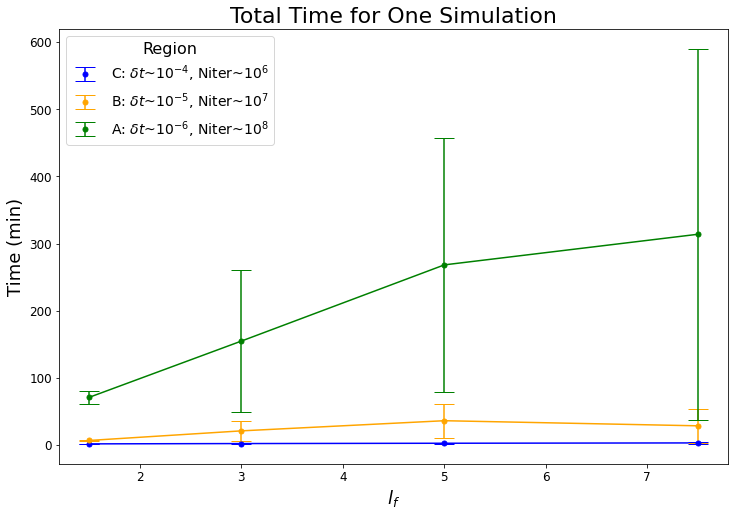

In [13]:
#----------------Plot analysis----------------#

    # Axis for Region C:
x_C = T_lf_C['lf']
y_C = T_lf_C['Total_time']
y_C_er = T_lf_C['Std_Time']

    # Axis for Region B:
x_B = T_lf_B['lf']
y_B = T_lf_B['Total_time']
y_B_er = T_lf_B['Std_Time']

    # Axis for Region A:
x_A = T_lf_A['lf']
y_A = T_lf_A['Total_time']
y_A_er = T_lf_A['Std_Time']

fig, ax = pl.subplots(figsize=(12, 8))

    # Initial settings for the plot:
ax.set_title('Total Time for One Simulation', size=22)
ax.tick_params(axis='both', labelsize=12)
ax.set_xlabel(r'$l_f$', size=18)
ax.set_ylabel('Time (min)', size=18)

pl.plot(x_C, y_C, c='blue')
pl.plot(x_B, y_B, c='orange')
pl.plot(x_A, y_A, c='green')

pl.errorbar(x_C, y_C, y_C_er,
            label=r'C: $\delta t$~$10^{-4}$, Niter~$10^6$', fmt='o', capsize=10, ms = 5, c='blue')
pl.errorbar(x_B, y_B, y_B_er,
            label=r'B: $\delta t$~$10^{-5}$, Niter~$10^7$', fmt='o', capsize=10, ms = 5, c='orange')
pl.errorbar(x_A, y_A, y_A_er,
            label=r'A: $\delta t$~$10^{-6}$, Niter~$10^8$', fmt='o', capsize=10, ms = 5, c='green')
pl.legend(title='Region', loc='upper left', fontsize=14, title_fontsize=16)

pl.show()

fig.savefig('Total_time_per_Simulation.png')
pl.close(fig)

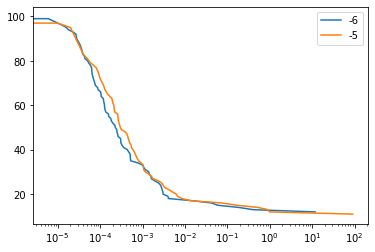

In [11]:
N_t1 = pd.read_csv('N100_Niter100000000_Nsim1_beta0.1_dt1e-06_lf1.0.csv')
N_t1

N_t2 = pd.read_csv('N100_Niter10000000_Nsim1_beta0.1_dt1e-05_lf1.5.csv')
N_t2

pl.plot(N_t1['t_1'], N_t1['N_1'], label='-6')
pl.plot(N_t2['t_1'], N_t2['N_1'], label='-5')
pl.legend()
pl.xscale('log')
pl.show()